In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [16]:
# reading in data

brownlow = pd.read_csv("brownlow_datathon_data.csv")
brownlow = brownlow.drop(columns="Unnamed: 0")
brownlow['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")

# get non 2018 data for testing

df = brownlow[brownlow['season'] != 2019]

In [17]:
df.tail()

,date,season,round,venue,ID,match_id,player,jumper_no,team,opposition,status,team_score,opposition_score,margin,brownlow_votes,CP,UP,ED,DE,CM,GA,MI5,one_perc,BO,TOG,K,HB,D,M,G,B,T,HO,I50,CL,CG,R50,FF,FA,AF,SC
76583,2018-08-26,2018,23,Docklands,1418,9708.0,J Waite,30,North Melbourne,St Kilda,Away,117,94,23,0.0,4.0,13.0,10.0,62.5,1.0,2.0,6.0,0.0,1.0,85.0,14.0,2.0,16.0,8.0,3.0,3.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,2.0,85.0,85.0
76584,2018-08-26,2018,23,Docklands,12084,9708.0,M Williams,2,North Melbourne,St Kilda,Away,117,94,23,0.0,5.0,15.0,15.0,83.3,0.0,0.0,0.0,3.0,1.0,83.0,12.0,6.0,18.0,4.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,69.0,77.0
76585,2018-08-26,2018,23,Docklands,12312,9708.0,M Wood,32,North Melbourne,St Kilda,Away,117,94,23,0.0,0.0,3.0,2.0,66.7,0.0,0.0,2.0,0.0,0.0,34.0,3.0,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,25.0
76586,2018-08-26,2018,23,Docklands,11755,9708.0,S Wright,19,North Melbourne,St Kilda,Away,117,94,23,0.0,10.0,17.0,22.0,75.9,0.0,0.0,0.0,0.0,1.0,83.0,16.0,13.0,29.0,8.0,0.0,0.0,2.0,0.0,3.0,0.0,4.0,4.0,1.0,0.0,107.0,96.0
76587,2018-08-26,2018,23,Docklands,11724,9708.0,J Ziebell,7,North Melbourne,St Kilda,Away,117,94,23,0.0,9.0,8.0,11.0,73.3,0.0,0.0,2.0,4.0,0.0,94.0,12.0,3.0,15.0,6.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,89.0,109.0


In [18]:
df.columns

Index(['date', 'season', 'round', 'venue', 'ID', 'match_id', 'player',
       'jumper_no', 'team', 'opposition', 'status', 'team_score',
       'opposition_score', 'margin', 'brownlow_votes', 'CP', 'UP', 'ED', 'DE',
       'CM', 'GA', 'MI5', 'one_perc', 'BO', 'TOG', 'K', 'HB', 'D', 'M', 'G',
       'B', 'T', 'HO', 'I50', 'CL', 'CG', 'R50', 'FF', 'FA', 'AF', 'SC'],
      dtype='object')

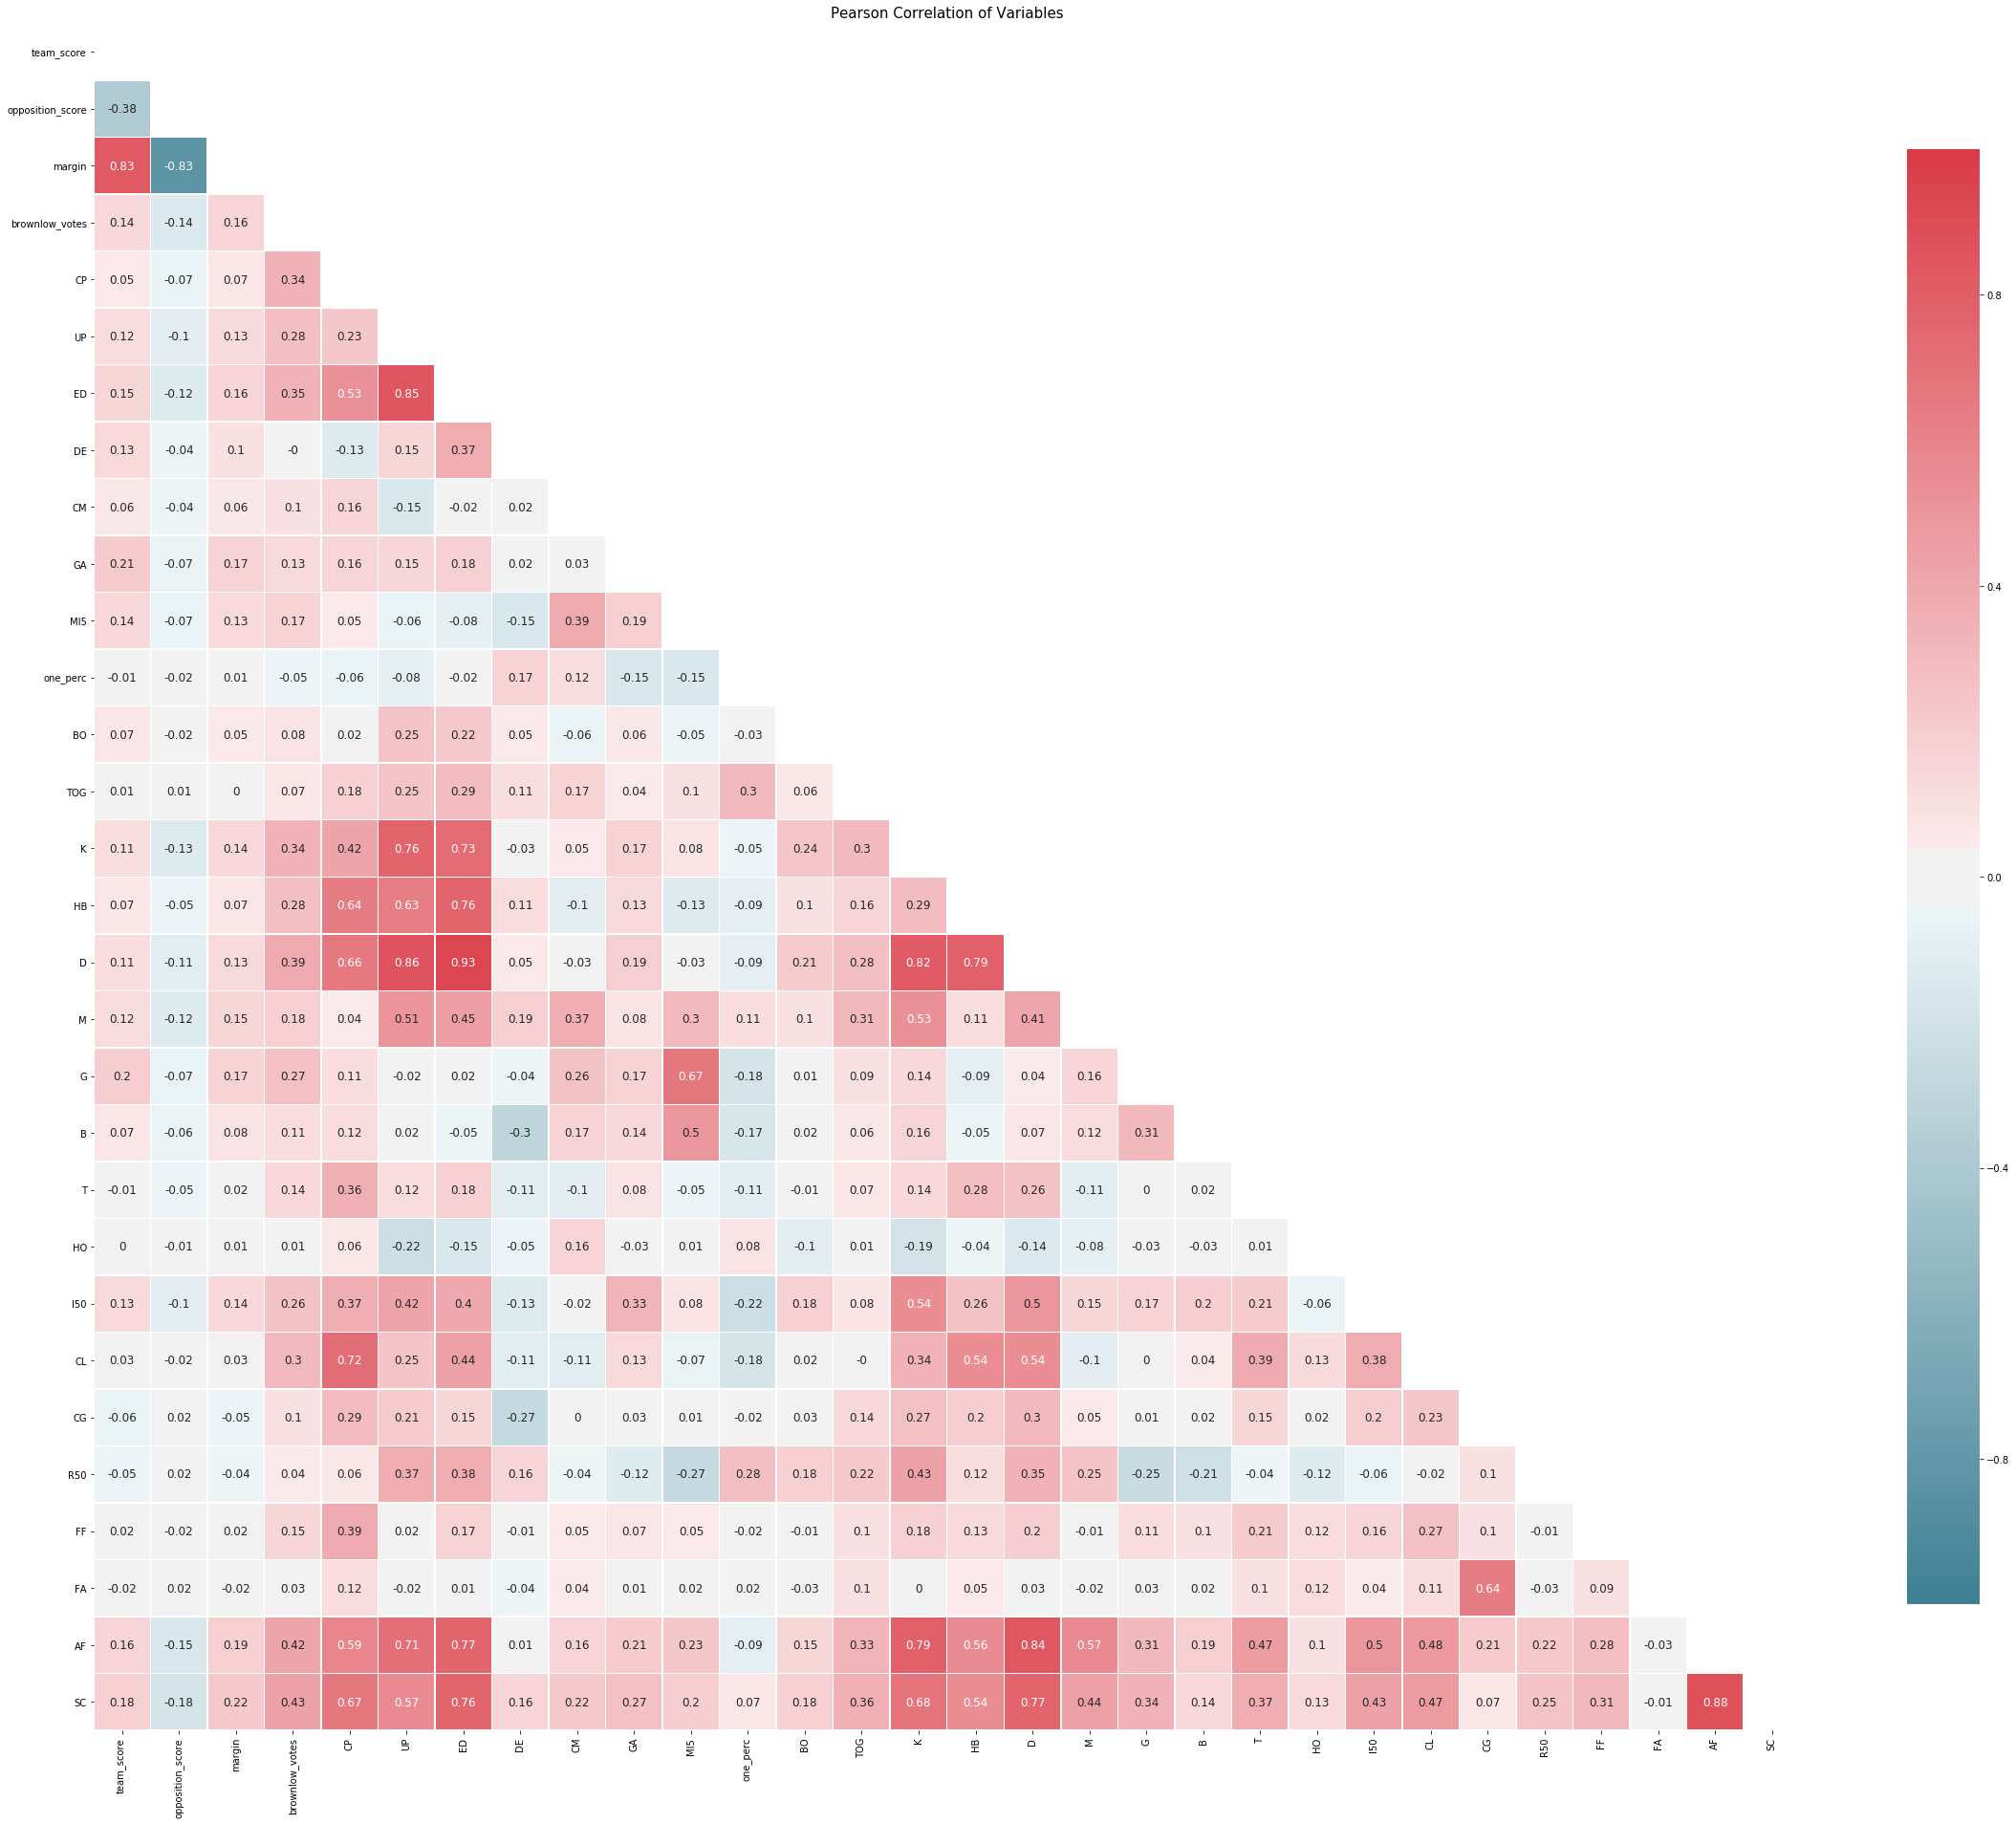

In [19]:
# check out correlation of features:

def corr_plot(df, title_name):
    _ , ax = plt.subplots(figsize=(40, 40))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    corr = round(df.corr(),2)
    # Generate a mask for the lower triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    _ = sns.heatmap(
        corr, mask=mask, cmap=cmap,
        square=True, 
        cbar_kws={'shrink':.7},
        
        ax=ax,
        annot=True, 
        linewidths=0.5,
        vmax=1.0, vmin=-1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title(title_name, y=1.05, size=15)

not_feature_cols = ['date', 'season', 'round', 'venue', 'ID', 'match_id', 'player', 'jumper_no', 'team', 'opposition', 'status']
    
features = [col for col in df.columns if col not in not_feature_cols]
corr_plot(df[features], title_name='Pearson Correlation of Variables')

In [22]:
corr = df[features].corr()

In [111]:
corr_cols = corr.abs().loc[:,corr["brownlow_votes"] > 0.3].columns[1:]
#feat_cols = [col for col in corr_cols if col != "brownlow_votes"]
feat_cols = [col for col in features if col != "brownlow_votes"]

In [112]:
feat_cols

['team_score',
 'opposition_score',
 'margin',
 'CP',
 'UP',
 'ED',
 'DE',
 'CM',
 'GA',
 'MI5',
 'one_perc',
 'BO',
 'TOG',
 'K',
 'HB',
 'D',
 'M',
 'G',
 'B',
 'T',
 'HO',
 'I50',
 'CL',
 'CG',
 'R50',
 'FF',
 'FA',
 'AF',
 'SC']

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# split test and train datasets

train = df[df['season'] < 2018]
test = df[df['season'] == 2018]

X_train = train[feat_cols]
y_train = train['brownlow_votes']

X_test = test[feat_cols]
y_test = test['brownlow_votes']

In [120]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and fit model
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_train_scaled, y_train)
#lgb_reg.fit(X_train, y_train)

# Create predictions
preds = lgb_reg.predict(X_test_scaled)
#preds = lgb_reg.predict(X_test)

In [122]:
preds_v2 = pd.DataFrame({
    'preds': preds
})

results = test[['player', 'brownlow_votes']].reset_index(drop=True)
results = results.join(preds_v2)
results = results.groupby('player')[['brownlow_votes', 'preds']].sum().sort_values('brownlow_votes', ascending=False)
results['mse'] = (results['preds'] - results['brownlow_votes'])**2
print(results['mse'].sum())
results.head()

1806.293974838026


,brownlow_votes,preds,mse
player,,,
T Mitchell,28.0,35.983347,63.733831
S Sidebottom,24.0,16.837773,51.297498
A Brayshaw,21.0,12.607844,70.428278
P Cripps,20.0,13.135828,47.116851
M Gawn,20.0,14.274251,32.784198


In [150]:
# predictions for 2019

val_train = brownlow[brownlow['season'] < 2019]
val_test = brownlow[brownlow['season'] == 2019]

X_val_train = val_train[feat_cols]
y_val_train = val_train['brownlow_votes']

X_val_test = val_test[feat_cols]

# Scale features
scaler = StandardScaler()
X_val_train_scaled = scaler.fit_transform(X_val_train)
X_val_test_scaled = scaler.transform(X_val_test)

# Instantiate and fit model
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(X_val_train_scaled, y_val_train)
#lgb_reg.fit(X_val_train, y_val_train)

# Create predictions
val_preds = lgb_reg.predict(X_val_test_scaled)
#preds = lgb_reg.predict(X_test)

preds_v3 = pd.DataFrame({
    'preds': val_preds
})

val = val_test[['player']].reset_index(drop=True)
val = val.join(preds_v3)
val = val.groupby('player')[['preds']].sum().sort_values('preds', ascending=False)

val.head(20)

,preds
player,
J Macrae,26.706688
A Treloar,26.066636
P Dangerfield,23.925122
L Neale,20.548458
J Dunkley,19.639436
B Grundy,19.530732
N Fyfe,19.138398
T Taranto,18.637463
D Martin,18.493767
